In [2]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV

# images = loadmat('baoimg.mat').get('img')
%run training_code/clean_cornets.py

In [3]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/HierStim/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}

qo = np.array(np.arange(0,400)); 
qe = np.array(np.arange(400,1660)); 
qf = np.array(np.arange(1660,2920)); 

In [ ]:
# Visualizing few images. 
xx = iter(dataloaders['train'])
# for i in range(6):
images, labels = next(xx)
grid = torchvision.utils.make_grid(images[:24,:,:,:]);
plt.figure(figsize = (10,100));
plt.imshow(grid.numpy().transpose((1, 2, 0)));

In [4]:
dataiter = iter(dataloaders['train'])

nBli = {}; nBli['v1'] = []; nBli['v2'] = []; nBli['v4'] = [];
nBli['it'] = []; nBli['h'] = []; nBli['out'] = []

net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# net.eval() 
    
for i in range(37):
    stimtemp, classes = next(dataiter)
    # nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())
    varV1, varV2, varV4, varIt, varh, varOut = net(stimtemp.float())
    nBli['v1'].extend(varV1.detach().numpy())
    nBli['v2'].extend(varV2.detach().numpy())
    nBli['v4'].extend(varV4.detach().numpy())
    nBli['it'].extend(varIt.detach().numpy())
    nBli['h'].extend(varh.detach().numpy())
    nBli['out'].extend(varOut.detach().numpy())
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


Text(0.5, 0.98, 'Non-biased literate network - PC space')

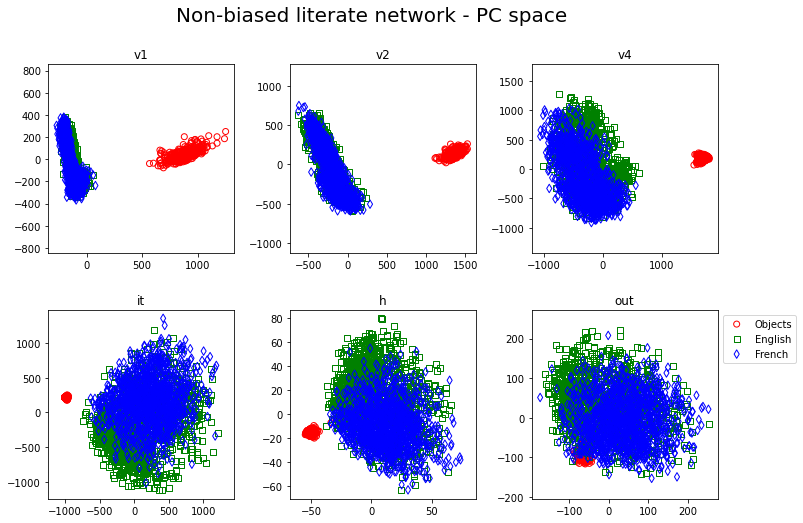

In [8]:
# PCA in python without any normalization or whiten matches PCA of MATLAB
from sklearn.decomposition import PCA
pcax = PCA(n_components=2)

fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

roi_ID = ['v1','v2','v4','it','h','out']
for idx in range(len(roi_ID)):
    
    out = pcax.fit_transform(nBli[roi_ID[idx]])
    axs[idx].scatter(out[qo, 0], out[qo, 1], marker='o',facecolors='none',edgecolor = 'r')
    axs[idx].scatter(out[qe, 0], out[qe, 1], marker= 's',facecolors='none',edgecolor = 'g')
    axs[idx].scatter(out[qf, 0], out[qf, 1], marker= 'd',facecolors='none',edgecolor = 'b')
    
    axs[idx].axis('equal');
    axs[idx].set_title(roi_ID[idx])
LEG = ['Objects', 'English', 'French']

plt.legend((LEG[:]), bbox_to_anchor=(1, 1))
fig.suptitle('Non-biased literate network - PC space', fontsize=20)

    

In [10]:
# Using predefined word selective units
neuid_e = [  9,  11,  12,  15,  17,  27,  28,  29,  39,  40,  55,  65,  73,
        75,  89, 123, 124, 150, 155, 169, 181, 189, 197, 201, 220, 226,
       241, 242, 243, 249, 258, 282, 283, 299, 300, 304, 341, 351, 354,
       361, 363, 367, 375, 381, 385, 395, 414, 422, 423, 427, 430, 437,
       442, 482, 485, 488, 496, 498, 506]

neuid_f = [  6,   9,  11,  12,  15,  17,  27,  28,  29,  39,  40,  55,  65,
        73,  75,  89, 123, 124, 150, 155, 169, 181, 189, 197, 201, 220,
       226, 241, 242, 243, 249, 250, 258, 282, 283, 299, 300, 304, 325,
       341, 351, 354, 355, 361, 363, 367, 375, 395, 414, 422, 423, 427,
       430, 437, 482, 485, 488, 496, 498, 506]

neuid_ef = np.intersect1d(neuid_f,neuid_e)

nid = {}
qt = list(set(neuid_e)^set(neuid_ef));    nid[0] = np.reshape(qt,[np.size(qt),1])
qt = list(set(neuid_f)^set(neuid_ef));    nid[1] = np.reshape(qt,[np.size(qt),1])
qt = list(set([])^set(neuid_ef));         nid[2] = np.reshape(qt,[np.size(qt),1])
type = ['English','French','English+French']

data_d = np.array(nBli['h'])


In [33]:
# Identifying word selective units
wqo = np.array(np.arange(0,400)); 
wqe = np.array(np.arange(1480,1660)); 
wqf = np.array(np.arange(1740,2920)); 
data_d = np.array(nBli['h'])

neuid_f = []; neuid_e = [];
for unit in range(np.size(data_d,1)):
    Enmean = np.mean(data_d[wqe,unit])
    Frmean = np.mean(data_d[wqf,unit])
    Objmean   = np.mean(data_d[wqo,unit])
    Objstdev  = np.var(data_d[wqo,unit])**0.5

    if Enmean >= Objmean + 3*Objstdev:
        neuid_e.append(unit)

    if Frmean >= Objmean + 3*Objstdev:
        neuid_f.append(unit)
        
neuid_ef = np.intersect1d(neuid_f,neuid_e)
print(['% of English word-selective units: ' + str(np.size(neuid_e)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_e))])
print(['% of French word-selective units: '+ str(np.size(neuid_f)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_f))])
print(['% of English & French word-selective units: ' + str(np.size(neuid_ef)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_ef))])


['% of English word-selective units: 0.10546875, count: 54']
['% of French word-selective units: 0.115234375, count: 59']
['% of English & French word-selective units: 0.09375, count: 48']


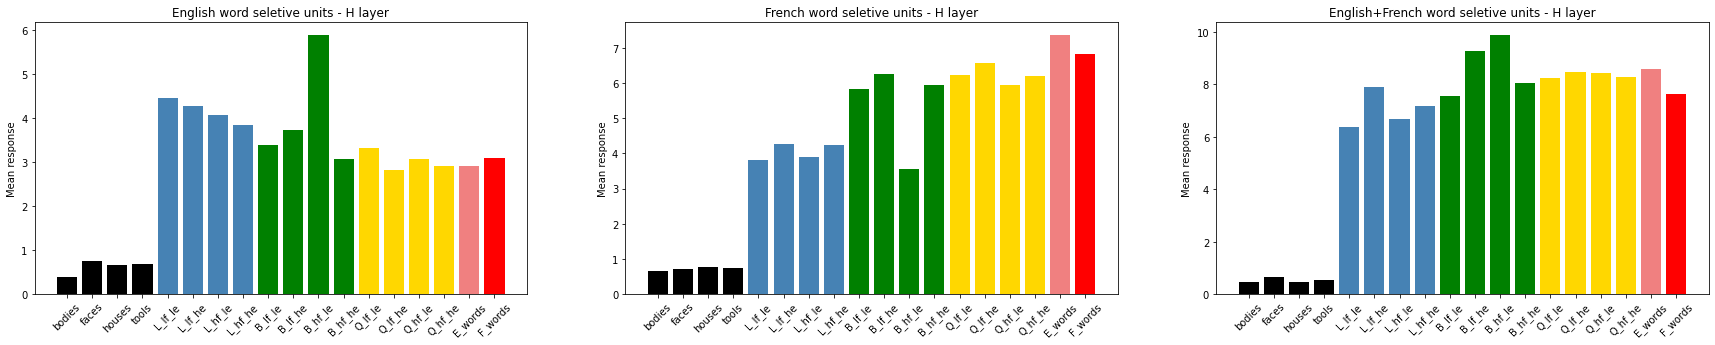

In [34]:
# Plotting the mean response averaged across all units
color = ['k','k','k','k','steelblue','steelblue','steelblue','steelblue',
         'green','green','green','green','gold','gold','gold','gold',
         'lightcoral','r']
label = ['bodies','faces','houses','tools','L_lf_le','L_lf_he','L_hf_le','L_hf_he',
         'B_lf_le','B_lf_he','B_hf_le','B_hf_he','Q_lf_le','Q_lf_he','Q_hf_le','Q_hf_he',
          'E_words', 'F_words']

fig, axs = plt.subplots(1,3, figsize=(30,5), facecolor='w', edgecolor='k')
axs = axs.ravel();

nid = {}
qt = list(set(neuid_e)^set(neuid_ef));    nid[0] = np.reshape(qt,[np.size(qt),1])
qt = list(set(neuid_f)^set(neuid_ef));    nid[1] = np.reshape(qt,[np.size(qt),1])
qt = list(set([])^set(neuid_ef));         nid[2] = np.reshape(qt,[np.size(qt),1])
type = ['English','French','English+French']

for i in range(3):
    meanresp = []
    for t in range(4):
        meanresp.append(np.nanmean(np.nanmean(data_d[np.arange(t*100,(t+1)*100),nid[i]],1),0))
    for t in range(14):
        meanresp.append(np.nanmean(np.nanmean(data_d[np.arange(400+t*180,400+(t+1)*180),nid[i]],1),0))


    axs[i].bar(range(18),meanresp,color = color)
    axs[i].set_xticks(range(18)); axs[i].set_xticklabels(label,rotation = 45)
    axs[i].set_ylabel('Mean response')
    axs[i].set_title(type[i]+ ' word seletive units - H layer')

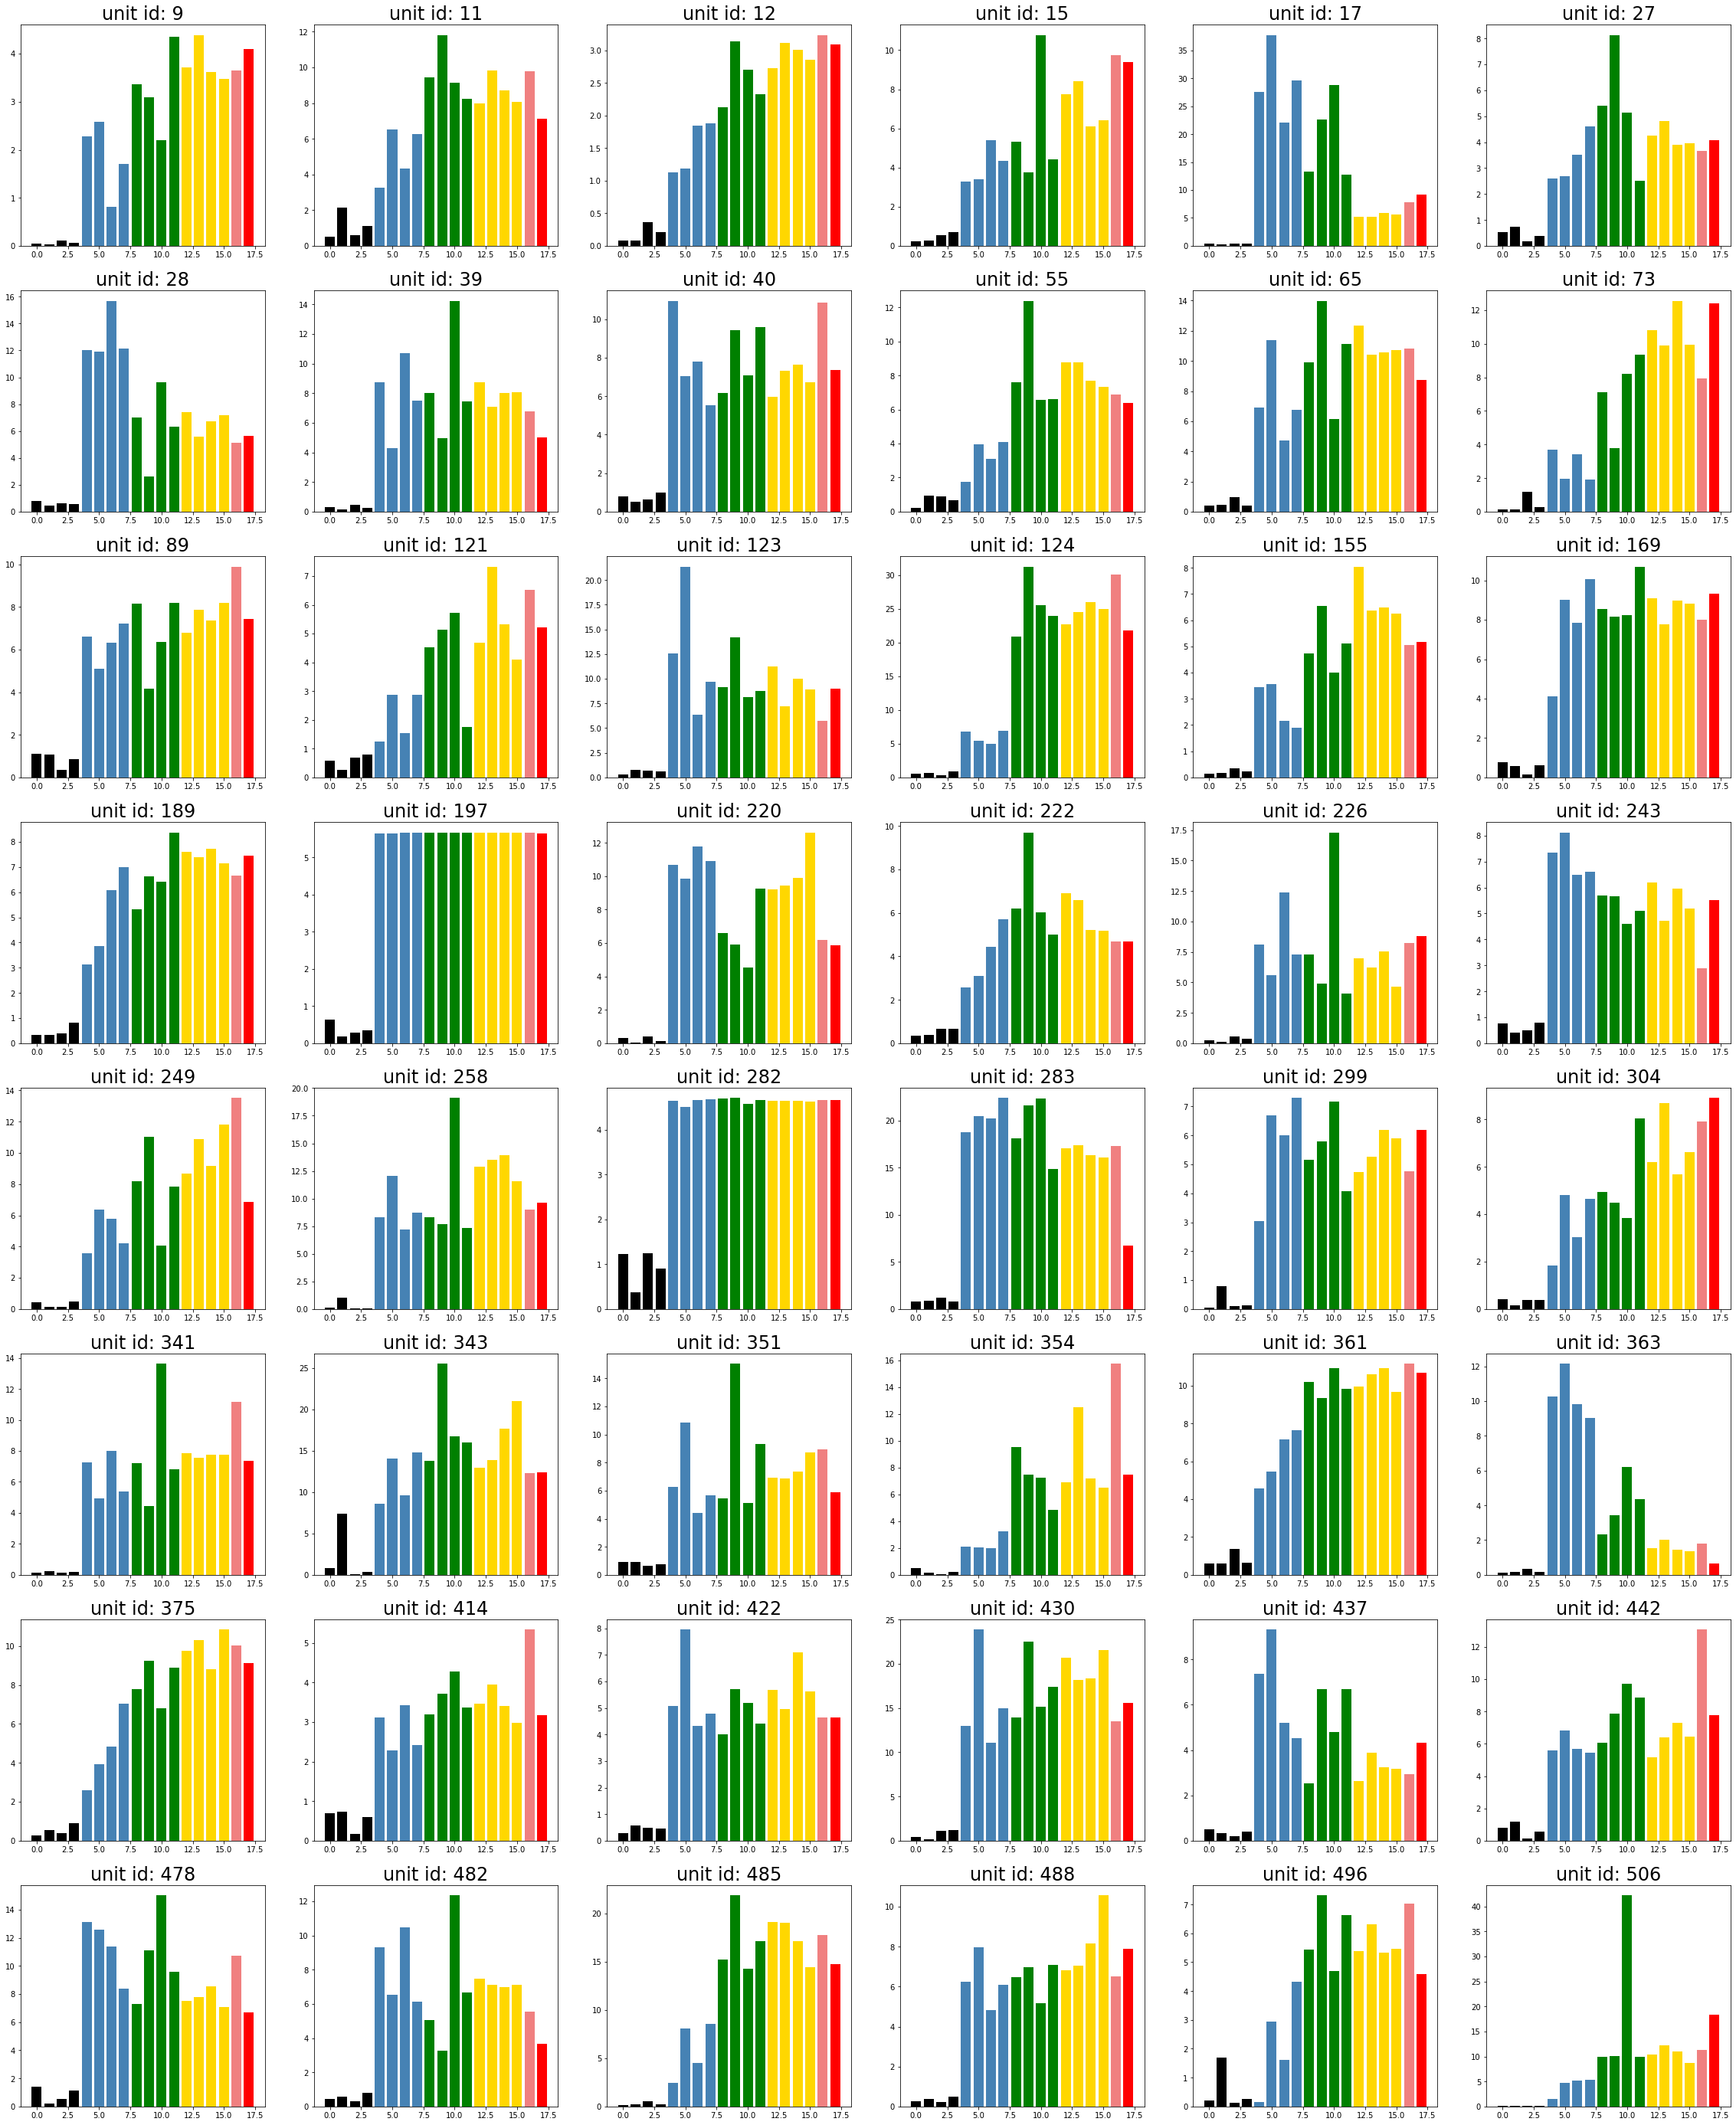

In [43]:
# Plotting the mean response for each unit in h layer
fig, axs = plt.subplots(8,6, figsize=(40,50), facecolor='w', edgecolor='k')
axs = axs.ravel();

color = ['k','k','k','k','steelblue','steelblue','steelblue','steelblue',
         'green','green','green','green','gold','gold','gold','gold',
         'lightcoral','r']
# color = ['k','k','k','k','b','c','green','limegreen','orange','gold','tomato','steelblue','skyblue','slateblue','orchid','lightcoral','r','maroon']
for n,nid in enumerate(np.sort(list(set([])^set(neuid_ef)))):
# for n,nid in enumerate(np.sort(neuid_fc)):
    meanresp = []
    for t in range(4):
        meanresp.append(np.nanmean(data_d[range(t*100,(t+1)*100),nid],0))
    for t in range(14):
        meanresp.append(np.nanmean(data_d[range(400+t*180,400+(t+1)*180),nid],0))
    
    axs[n].bar(range(18),meanresp,color = color)
    axs[n].set_title('unit id: ' + str(nid),fontsize = 24)
# fig.suptitle('Chinese selective units', fontsize = 32)

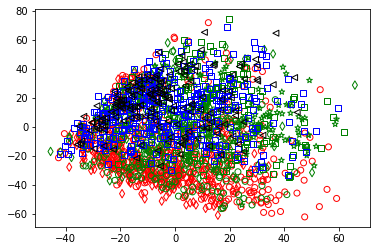

In [50]:
# Visualizing PC space for word selective units
from sklearn.decomposition import PCA
pcax = PCA(n_components=3)

out = pcax.fit_transform(data_d[400:,neuid_ef])
cmarker = ['r','r','r','r','g','g','g','g','b','b','b','b','k','k']
point = ['o', 'd','o', 'd','o', 'd','*', 's','+', 's','+','s','+','<']
for i in range(14):
    idx = np.arange(180*(i-1),180*i,1)
    plt.scatter(out[idx,2],out[idx,0],marker=point[i],facecolors='none',edgecolor = cmarker[i])
